In [26]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import os

train:2006-4-1 to 2040-12-31; test:2050-4-1 to 2080-11-30

Error of different LSTM Models During this Test Period

In [18]:
# Set up paths
prediction_dirs = {
    **{f'Model_{i}': 'LSTM_MME_prediction' for i in range(3, 9)},
    'Model_85': 'LSTM_CHESS_prediction'
}

# Time range
start_date = '2050-04-01'
end_date = '2080-11-30'

# Store RMSE results
rmse_results_LSTM = {}

# Iterate over all models
for model_name, folder in prediction_dirs.items():
    file_path = f'{folder}/{model_name.lower()}_test_predictions.csv'
    try:
        df = pd.read_csv(file_path, parse_dates=['date'])
        # Select the test period
        df = df[(df['date'] >= start_date) & (df['date'] <= end_date)]
        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(df['Actual'], df['Predicted']))
        rmse_results_LSTM[model_name] = rmse
    except FileNotFoundError:
        print(f"{model_name} - Prediction file not found.")

df_LSTM = pd.DataFrame([
    {'model_id': int(k.split('_')[1]), 'rmse': v}
    for k, v in rmse_results_LSTM.items()
    if k in [f'Model_{i}' for i in range(3, 9)]
])
df_LSTM

,model_id,rmse
0,3,2.080055
1,4,1.897108
2,5,1.901999
3,6,1.933100
4,7,1.979291
5,8,1.953860


Error of different RF Models During this Test Period

In [19]:
# Set up directories
prediction_dirs = {
    **{f'Model_{i}': 'RF_MME_prediction' for i in range(3, 9)},
    'Model_85': 'RF_CHESS_prediction'
}

# Time range
start_date = '2050-04-01'
end_date = '2080-11-30'

# Store RMSE results
rmse_results_RF = {}

# Iterate over all models
for model_name, folder in prediction_dirs.items():
    file_path = f'{folder}/{model_name.lower()}_test_predictions.csv'
    try:
        df = pd.read_csv(file_path, parse_dates=['date'])
        # Select the test period
        df = df[(df['date'] >= start_date) & (df['date'] <= end_date)]
        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(df['Actual'], df['Predicted']))
        rmse_results_RF[model_name] = rmse
    except FileNotFoundError:
        print(f"{model_name} - Prediction file not found.")
        
df_RF = pd.DataFrame([
    {'model_id': int(k.split('_')[1]), 'rmse': v}
    for k, v in rmse_results_RF.items()
    if k in [f'Model_{i}' for i in range(3, 9)]
])
df_RF

,model_id,rmse
0,3,2.034443
1,4,1.981770
2,5,1.966694
3,6,2.022629
4,7,2.037620
5,8,2.060217


## Stacking

In [20]:
# List of model IDs
day_models = [3, 4, 5, 6, 7, 8]

# Store RMSE results for each model
results = []

# Iterate through each model
for model_id in day_models:
    # Read training data
    train_file = f'stacking_data_model_train_{model_id}.xlsx'
    train_df = pd.read_excel(train_file)

    # Read testing data
    test_file = f'stacking_data_model_test_{model_id}.xlsx'
    test_df = pd.read_excel(test_file)

    # Define features and target
    features = ['LSTM_day', 'RF_day', 'LSTM_85', 'RF_85']
    X_train = train_df[features]
    y_train = train_df['Actual']
    X_test = test_df[features]
    y_test = test_df['Actual']
    
    # Train Random Forest Regressor as stacking model
    model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Compute RMSE
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    # Store results
    results.append({
        'model_id': model_id,
        'rmse': rmse
    })

# Output RMSE results for all models
df_stacking_1 = pd.DataFrame(results)
df_stacking_1

,model_id,rmse
0,3,2.110478
1,4,2.064789
2,5,2.073191
3,6,2.100484
4,7,2.143762
5,8,2.152854


In [21]:
# List of model IDs
day_models = [3, 4, 5, 6, 7, 8]

# Store RMSE results for each model
results = []

# Iterate through each model
for model_id in day_models:
    # Read training data
    train_file = f'stacking_data_model_train_{model_id}.xlsx'
    train_df = pd.read_excel(train_file)

    # Read testing data
    test_file = f'stacking_data_model_test_{model_id}.xlsx'
    test_df = pd.read_excel(test_file)

    # Define features and target
    features = ['LSTM_day', 'RF_day']
    X_train = train_df[features]
    y_train = train_df['Actual']
    X_test = test_df[features]
    y_test = test_df['Actual']
    
    # Train Random Forest Regressor as stacking model
    model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Compute RMSE
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    # Store results
    results.append({
        'model_id': model_id,
        'rmse': rmse
    })

# Output RMSE results for all models
df_stacking_2 = pd.DataFrame(results)
df_stacking_2

,model_id,rmse
0,3,2.112640
1,4,2.067093
2,5,2.077693
3,6,2.105547
4,7,2.143705
5,8,2.157239


### Evaluation

In [24]:
# Add method labels to each DataFrame
df_LSTM['method'] = 'LSTM'
df_RF['method'] = 'RandomForest'
df_stacking_1['method'] = 'Stacking_1'
df_stacking_2['method'] = 'Stacking_2'

# Combine all RMSE results into a single DataFrame
df_all = pd.concat([df_LSTM, df_RF, df_stacking_1, df_stacking_2], ignore_index=True)

# Pivot the table for comparison: rows = model_id, columns = method, values = RMSE
rmse_comparison = df_all.pivot(index='model_id', columns='method', values='rmse')

rmse_comparison

method,LSTM,RandomForest,Stacking_1,Stacking_2
model_id,,,,
3,2.080055,2.034443,2.110478,2.112640
4,1.897108,1.981770,2.064789,2.067093
5,1.901999,1.966694,2.073191,2.077693
6,1.933100,2.022629,2.100484,2.105547
7,1.979291,2.037620,2.143762,2.143705
8,1.953860,2.060217,2.152854,2.157239


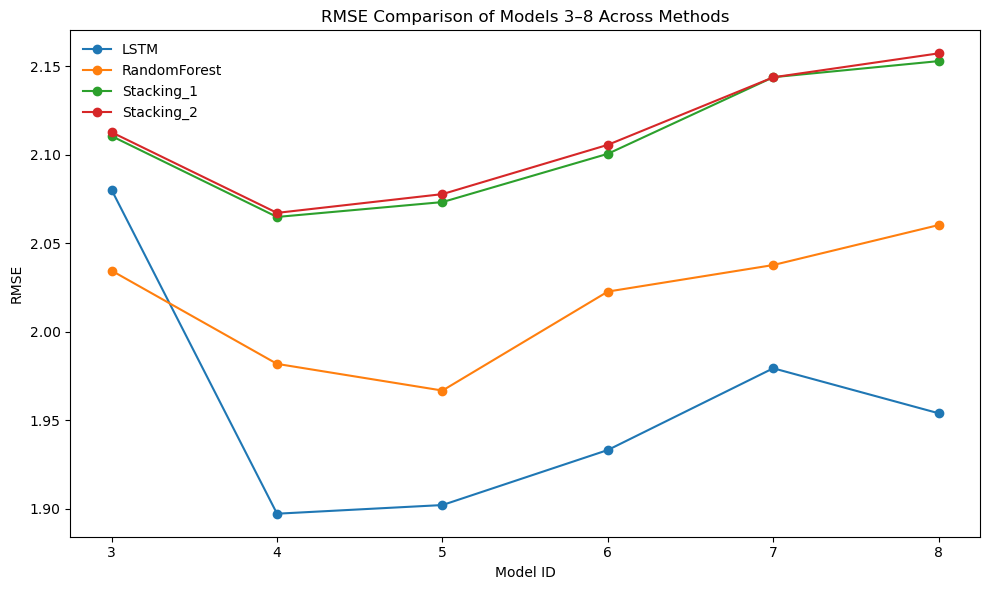

In [32]:
# Line plot
plt.figure(figsize=(10, 6))
for method in rmse_comparison.columns:
    plt.plot(rmse_comparison.index, rmse_comparison[method], marker='o', label=method)
plt.title('RMSE Comparison of Models 3–8 Across Methods')
plt.xlabel('Model ID')
plt.ylabel('RMSE')
plt.legend(frameon=False)
plt.tight_layout()
plt.show()